In [2]:
import numpy as np
import pandas as pd

log_pr_file = './log_price.df'
volu_usd_file = './volume_usd.df'

In [3]:
log_pr = pd.read_pickle(log_pr_file)
volu = pd.read_pickle(volu_usd_file)
log_pr.columns = ['log_pr_%d'%i for i in range(10)]
volu.columns = ['volu_%d'%i for i in range(10)]

data = pd.concat([log_pr, volu], axis=1)

#### Dataset manipulation

In [4]:
def _split_data(data:pd.DataFrame, test_pct:float):
    assert test_pct > 0 and test_pct < 1
    test_size = int(len(data) * test_pct)
    return  data[:-test_size], data[-test_size:]

def split_data(log_pr:pd.DataFrame, volu:pd.DataFrame, test_pct:float):
    return *_split_data(log_pr, test_pct), *_split_data(volu, test_pct)

In [5]:
def formulize_data(data:pd.DataFrame, log_pr:pd.DataFrame, window_size=1440, step=10) -> np.array:
    N = len(data)
    assert N == len(log_pr)
    train_index = np.arange(0, window_size)[np.newaxis, :] + np.arange(0, N - window_size - 30, step)[:, np.newaxis]
    return_index = np.arange(0, N - window_size - 30, step)[:, np.newaxis] + window_size + 30 - 1
#     print(train_index, return_index)
    return data.values[train_index], log_pr.values[return_index]

#### Featue generator functions

In [6]:
def rate_of_change(data:pd.DataFrame, periods):
    return data.pct_change(periods)

In [7]:
def moving_average(data:pd.DataFrame, window_size):
    return data.rolling(window_size).mean()

In [8]:
def exp_moving_avg(data:pd.DataFrame, window_size):
    return data.ewm(com = window_size - 1, adjust=True, min_periods = window_size).mean()

In [9]:
def z_score(data:pd.DataFrame, window_size):
    assert window_size > 1
    return (data - data.rolling(window=window_size).mean()) / \
            data.rolling(window=window_size).std()

In [10]:
def moving_sum(data:pd.DataFrame, window_size):
    return data.rolling(window_size).sum()

In [11]:
def sign(data:pd.DataFrame):
    return np.sign(data)

In [12]:
def binning(data:pd.DataFrame, n_bins):
    bin_fn = lambda y: pd.qcut(y, q=n_bins, labels=range(1, n_bins+1))
    return data.apply(bin_fn)

In [13]:
def RSI(data:pd.DataFrame, window_size, ema=True):
    """
    Returns a pd.Series with the relative strength index.
    """
    # Make two series: one for lower closes and one for higher closes
    up = data.clip(lower=0)
    down = -1 * data.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = window_size - 1, adjust=True, min_periods = window_size).mean()
        ma_down = down.ewm(com = window_size - 1, adjust=True, min_periods = window_size).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = window_size, adjust=False).mean()
        ma_down = down.rolling(window = window_size, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi.dropna()

In [14]:
def MACD(data:pd.DataFrame, window_slow=26, window_fast=12, window_signal=9):
    ema_slow = exp_moving_avg(data, window_slow)
    ema_fast = exp_moving_avg(data, window_fast)
    ema_signal = exp_moving_avg(data, window_signal)
    macd = ema_fast - ema_slow
    return macd, macd - ema_signal

In [15]:
def high_low(data:pd.DataFrame, window=52):
    high = data.rolling(window=window).max()
    low = data.rolling(window=window).min()
    return high, low

In [16]:
def RHP(data:pd.DataFrame, window=10, horizon=52):
    high, low = high_low(data, horizon)
    newhighs = (high == data).sum(axis=1)
    newlows = (low == data).sum(axis=1)
    rhp = newhighs / (newhighs + newlows + 1e-4)
    return rhp.rolling(window=window).mean()

In [17]:
def BollingerBands(data:pd.DataFrame, window_size):
    ma = data.rolling(window=window_size).mean()
    sd = data.rolling(window=window_size).std()
    up = ma + 2*sd
    down = ma - 2*sd
    return up, down

In [18]:
def TRIN(log_pr:pd.DataFrame, volu:pd.DataFrame, window=1):
    num_stocks = log_pr.shape[1]
    pr_adv = (log_pr.diff(window) > 0).sum(axis=1)
    v_adv = (volu.diff(window) > 0).sum(axis=1)
    trin = (pr_adv / (num_stocks - pr_adv + 1e-4)) / (v_adv / (num_stocks - v_adv + 1e-4) + 1e-4)
    return trin

In [19]:
def ADL(data:pd.DataFrame, window=1):
    num = data.shape[1]
    adv = (data.diff(window) > 0).sum(axis=1)
    return adv - (num - adv)

#### Feature generator pipeline

In [20]:
# construct features
def generate_features(log_pr:pd.DataFrame, volu:pd.DataFrame):
    # 30 min negative returns
    n_ret = -(log_pr - log_pr.shift(30))
    n_ret.columns = ['30rt%d'%i for i in range(10)]
    
    # log volumes
    log_volu = np.log(volu + 1)
    log_volu.columns = ['lgv%d'%i for i in range(10)]
    
    # price diff
    pr_diff = []
    for d in [1, 10, 30]:
        pr_diff.append(log_pr.diff(d))
        pr_diff[-1].columns = ['prdif%d%d'%(d, i) for i in range(10)]
        
    # volume diff
    volu_diff = []
    for d in [1, 10, 30]:
        volu_diff.append(volu.diff(d))
        volu_diff[-1].columns = ['vdif%d%d'%(d, i) for i in range(10)]
        
    # price rate of change
    pr_roc = []
    for window in [1, 10, 30, 40, 60, 120, 1440 - 60]:
        pr_roc.append(rate_of_change(log_pr, window))
        pr_roc[-1].columns = ['prroc%d%d'%(window, i) for i in range(10)]
        
    # volume rate of change
    v_roc = []
    for window in [10, 30, 40, 60, 120, 1440 - 60]:
        v_roc.append(rate_of_change(volu + 1, window))
        v_roc[-1].columns = ['vroc%d%d'%(window, i) for i in range(10)]
        
    # price moving average
    pr_ma =[]
    for window in [1, 10, 30, 40, 60, 120, 1440 - 60]:
        pr_ma.append(moving_average(log_pr, window))
        pr_ma[-1].columns = ['prma%d%d'%(window, i) for i in range(10)]
        
    # volume moving average
    v_ma = []
    for window in [1, 10, 30, 40, 60, 120, 1440 - 60]:
        v_ma.append(moving_average(volu, window))
        v_ma[-1].columns = ['vma%d%d'%(window, i) for i in range(10)]
        
    # price exp moving average
    pr_ema =[]
    for window in [1, 10, 30, 40, 60, 120, 1440 - 60]:
        pr_ema.append(exp_moving_avg(log_pr, window))
        pr_ema[-1].columns = ['prema%d%d'%(window, i) for i in range(10)]
        
    # volume exp moving average
    v_ema = []
    for window in [1, 10, 30, 40, 60, 120, 1440 - 60]:
        v_ema.append(exp_moving_avg(volu, window))
        v_ema[-1].columns = ['vema%d%d'%(window, i) for i in range(10)]
        
    # z score
    pr_z = []
    for window in [10, 30, 40, 60, 120, 1440 - 60]:
        pr_z.append(z_score(log_pr, window))
        pr_z[-1].columns = ['prz%d%d'%(window, i) for i in range(10)]
        
    # volume z score
    v_z = []
    for window in [10, 30, 40, 60, 120, 1440 - 60]:
        v_z.append(z_score(volu, window))
        v_z[-1].columns = ['vz%d%d'%(window, i) for i in range(10)]
        
    # RSI indicators
    rsi = RSI(log_pr, 14)
    rsi.columns = ['rsi%d'%i for i in range(10)]
    
    # MACD indicators
    macd, macd_r = MACD(log_pr)
    macd.columns = ['macd%d'%i for i in range(10)]
    macd_r.columns = ['macd%d'%i for i in range(10)]
    
    # high low indicators
    high, low = high_low(log_pr)
    high.columns = ['high%d'%i for i in range(10)]
    low.columns = ['low%d'%i for i in range(10)]
    
    # high low ratio
    rhp = RHP(log_pr)
    rhp = pd.DataFrame(rhp, columns=['rhp'])
    
    # BollingerBands
    upbb, downbb = BollingerBands(log_pr, 10)
    upbb.columns = ['upbb%d'%i for i in range(10)]
    downbb.columns = ['downbb%d'%i for i in range(10)]
    
    # TRIN
    trin = TRIN(log_pr, volu)
    trin = pd.DataFrame(trin, columns=['trin'])
    
    # ADL
    adl = ADL(log_pr)
    adl = pd.DataFrame(adl, columns=['adl'])
    
    import itertools
    features = pd.concat([log_pr, volu, 
                          n_ret, log_volu, *pr_diff, *volu_diff, 
                          *pr_roc, *v_roc, *pr_ma, *v_ma, 
                          *pr_ema, *v_ema, *pr_z, *v_z,
                          rsi, macd, high, low, rhp, 
                          upbb, downbb, trin, adl], axis=1)
    return features
    
    

In [21]:
features = generate_features(log_pr, volu)

In [22]:
features.columns

Index(['log_pr_0', 'log_pr_1', 'log_pr_2', 'log_pr_3', 'log_pr_4', 'log_pr_5',
       'log_pr_6', 'log_pr_7', 'log_pr_8', 'log_pr_9',
       ...
       'downbb2', 'downbb3', 'downbb4', 'downbb5', 'downbb6', 'downbb7',
       'downbb8', 'downbb9', 'trin', 'adl'],
      dtype='object', length=693)

In [23]:
features.to_pickle('./features.pkl')

#### Forge training set and test set

In [24]:
log_pr_tr, log_pr_tst, volu_tr,  volu_tst = split_data(log_pr, volu, 0.3)

In [25]:
log_pr_tr.shape, log_pr_tst.shape, volu_tr.shape, volu_tst.shape

((185472, 10), (79488, 10), (185472, 10), (79488, 10))

In [26]:
features_tr = generate_features(log_pr_tr, volu_tr)

In [27]:
features_tr.shape, features.columns, features_tr.dropna().shape

((185472, 693),
 Index(['log_pr_0', 'log_pr_1', 'log_pr_2', 'log_pr_3', 'log_pr_4', 'log_pr_5',
        'log_pr_6', 'log_pr_7', 'log_pr_8', 'log_pr_9',
        ...
        'downbb2', 'downbb3', 'downbb4', 'downbb5', 'downbb6', 'downbb7',
        'downbb8', 'downbb9', 'trin', 'adl'],
       dtype='object', length=693),
 (184092, 693))

In [28]:
features_tr.to_pickle('./features_tr.pkl')

In [29]:
features_tr_f, label_tr_f = formulize_data(features_tr.dropna(), log_pr_tr.loc[features_tr.dropna().index], window_size=3)
features_tr_f.shape, label_tr_f.shape

((18406, 3, 693), (18406, 1, 10))

In [30]:
np.save('./features_tr_f.pkl', features_tr_f)
np.save('./labels_tr_f.pkl', label_tr_f)

#### Train and save a simple linear model

In [63]:
from sklearn.linear_model import LinearRegression
N = len(features_tr_f)
model = LinearRegression()
model.fit(features_tr_f.reshape(N, -1), label_tr_f.squeeze())
model.score(features_tr_f.reshape(N, -1), label_tr_f.squeeze())

0.9988272726243963

In [64]:
# save the file
import pickle
with open('./feature_linreg.pkl', 'wb') as f:
    pickle.dump(model, f)

In [65]:
import pickle
with open('./feature_linreg.pkl', 'rb') as f:
    file_model = pickle.load(f)

In [66]:
from critic import Critic
cr = Critic()
from tqdm import tqdm
def get_r_hat(A, B):
#     print(A.shape, B.shape)
    features = generate_features(A, B).dropna()
    features_tr = features[-3:]
    # print(features_tr.shape)
    pred = file_model.predict(features_tr.values.reshape(1, -1))
    return pred - A.values[-1]
    
cr.submit(get_r_hat, log_pr_tst, volu_tst)

100%|██████████| 7805/7805 [09:57<00:00, 13.05it/s]

Total time used: 597.955s
Pairwise correlation:
	asset 0 = 0.00922
	asset 1 = -0.00610
	asset 2 = 0.01215
	asset 3 = 0.01271
	asset 4 = 0.05252
	asset 5 = -0.02366
	asset 6 = 0.04410
	asset 7 = 0.00385
	asset 8 = -0.05468
	asset 9 = -0.00688
	mean correlation = 0.00432
Overall correlation: 0.00634
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


(597.9553079605103,
 0    0.009221
 1   -0.006103
 2    0.012149
 3    0.012707
 4    0.052524
 5   -0.023663
 6    0.044095
 7    0.003845
 8   -0.054679
 9   -0.006883
 dtype: float64,
 0.0063425222829207656)

#### Feature Selection

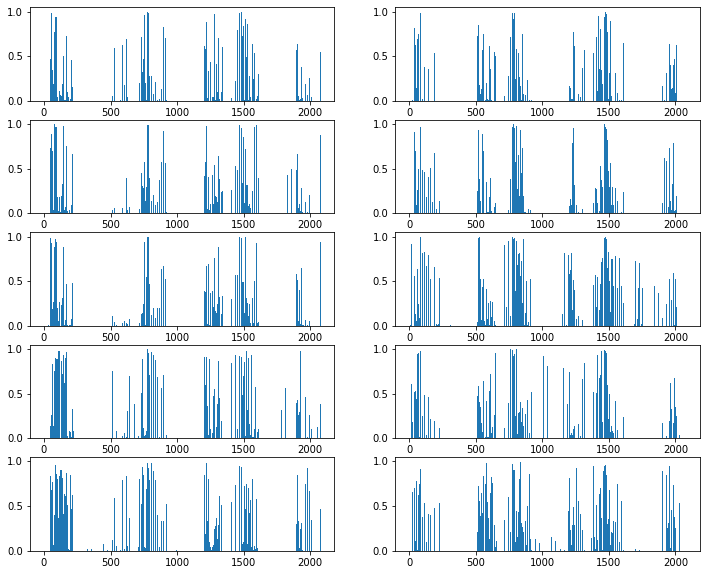

In [31]:
from joblib import delayed, Parallel
from sklearn.feature_selection import f_regression, SelectKBest
import matplotlib.pyplot as plt

N = len(features_tr_f)

def plot_corr_score(features, label):
    fs = SelectKBest(score_func=f_regression, k='all')
    fs.fit(features, label)
    return np.concatenate([fs.scores_, fs.pvalues_], axis=0)

rank_array_cor = Parallel(n_jobs=6)(delayed(plot_corr_score)(features_tr_f.reshape(N, -1), label_tr_f[:,:,i]) for i in range(10))

_, ax = plt.subplots(5, 2, figsize=(12,10))
for i, rank in enumerate(rank_array_cor):
    p_values = rank[len(rank)//2:]
    ax[i // 2, i % 2].bar([i for i in range(len(p_values))], p_values)
plt.show()

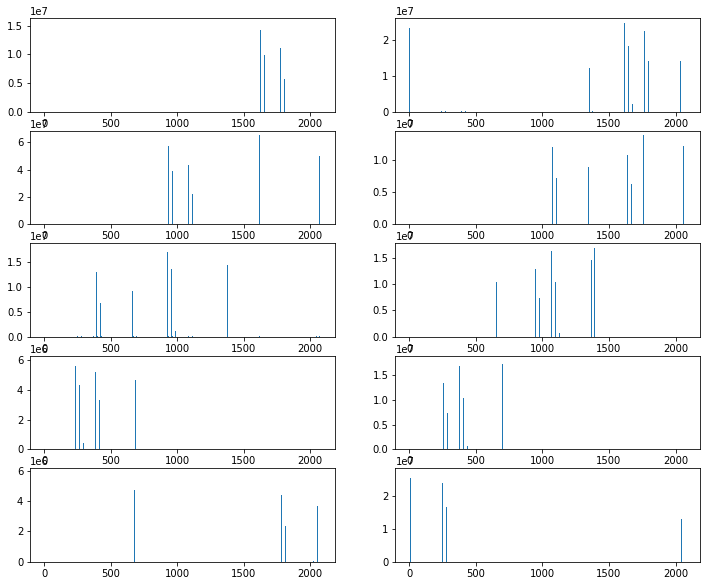

In [32]:
_, ax = plt.subplots(5, 2, figsize=(12,10))
for i, rank in enumerate(rank_array_cor):
    f_values = rank[:len(rank)//2]
    ax[i // 2, i % 2].bar([i for i in range(len(f_values))], f_values)
plt.show()

In [33]:
threshold = 0.001
selected_cor_p = []
for i, rank in enumerate(rank_array_cor):
    # print(rank)
    p_values = rank[len(rank)//2:]
    selected_cor_p.append(np.where(p_values < threshold)[0])
    print("features of asset %d with p-value < %.4f: num = %d"%(i, threshold, len(selected_cor_p[-1])))

features of asset 0 with p-value < 0.0010: num = 1193
features of asset 1 with p-value < 0.0010: num = 1184
features of asset 2 with p-value < 0.0010: num = 1134
features of asset 3 with p-value < 0.0010: num = 1181
features of asset 4 with p-value < 0.0010: num = 1181
features of asset 5 with p-value < 0.0010: num = 974
features of asset 6 with p-value < 0.0010: num = 1145
features of asset 7 with p-value < 0.0010: num = 1117
features of asset 8 with p-value < 0.0010: num = 1078
features of asset 9 with p-value < 0.0010: num = 1072


In [34]:
threshold = 6366
selected_cor_f = []
for i, rank in enumerate(rank_array_cor):
    # print(rank)
    f_values = rank[:len(rank)//2]
    selected_cor_f.append(np.where(f_values > threshold)[0])
    print("features of asset %d with f-value < %.4f: num = %d"%(i, threshold, len(selected_cor_f[-1])))

features of asset 0 with f-value < 6366.0000: num = 381
features of asset 1 with f-value < 6366.0000: num = 420
features of asset 2 with f-value < 6366.0000: num = 444
features of asset 3 with f-value < 6366.0000: num = 348
features of asset 4 with f-value < 6366.0000: num = 441
features of asset 5 with f-value < 6366.0000: num = 192
features of asset 6 with f-value < 6366.0000: num = 150
features of asset 7 with f-value < 6366.0000: num = 417
features of asset 8 with f-value < 6366.0000: num = 183
features of asset 9 with f-value < 6366.0000: num = 507


Find all features with significant p-value and significant f-value.

In [35]:
selected_cor = []
for i in range(10):
    selected_cor.append(np.intersect1d(selected_cor_p[i], selected_cor_f[i], True))
    print("features selected with correlation score for asset %d: %d"%(i, len(selected_cor[-1])))

features selected with correlation score for asset 0: 381
features selected with correlation score for asset 1: 420
features selected with correlation score for asset 2: 444
features selected with correlation score for asset 3: 348
features selected with correlation score for asset 4: 441
features selected with correlation score for asset 5: 192
features selected with correlation score for asset 6: 150
features selected with correlation score for asset 7: 417
features selected with correlation score for asset 8: 183
features selected with correlation score for asset 9: 507


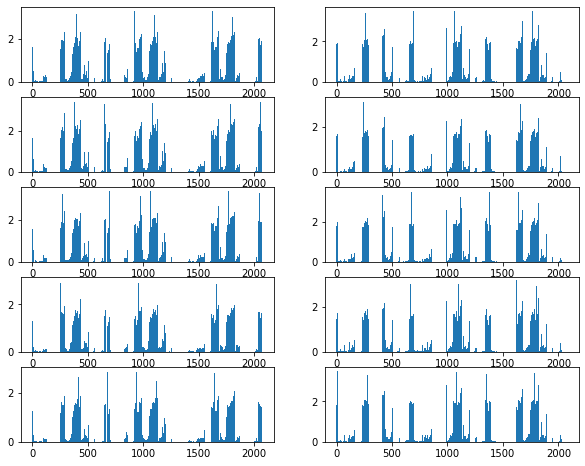

In [36]:
# mutual information
from joblib import delayed, Parallel
from sklearn.feature_selection import mutual_info_regression, SelectKBest
import matplotlib.pyplot as plt

def plot_corr_score(features, label, ax):
    fs = SelectKBest(score_func=mutual_info_regression, k='all')
    fs.fit(features, label)
    return fs.scores_

score_array = Parallel(n_jobs=6)(delayed(plot_corr_score)(features_tr_f.reshape(N,-1), label_tr_f[:,:,i], ax) for i in range(10))

_, ax = plt.subplots(5, 2, figsize=(10,8))
for i, scores in enumerate(score_array):
    ax[i // 2, i % 2].bar([i for i in range(len(scores))], scores)
plt.show()

In [37]:
threshold = 1
selected_mi = []
for i, score in enumerate(score_array):
    selected_mi.append(np.where(score > threshold)[0])
    print("features of asset %d with mi-value > %.4f: num = %d"%(i, threshold, len(selected_mi[-1])))

features of asset 0 with mi-value > 1.0000: num = 624
features of asset 1 with mi-value > 1.0000: num = 636
features of asset 2 with mi-value > 1.0000: num = 633
features of asset 3 with mi-value > 1.0000: num = 621
features of asset 4 with mi-value > 1.0000: num = 632
features of asset 5 with mi-value > 1.0000: num = 630
features of asset 6 with mi-value > 1.0000: num = 615
features of asset 7 with mi-value > 1.0000: num = 621
features of asset 8 with mi-value > 1.0000: num = 605
features of asset 9 with mi-value > 1.0000: num = 639


Unique features that might have non-linear relationship with target

In [69]:
non_sig_linear_features = []
for i in range(10):
    non_sig_linear_features.append(np.setdiff1d(selected_cor[i], selected_mi[i], True))
    print("features of asset %d that assumed to be linear but not significant: num=%d"%(i, len(non_sig_linear_features[-1])))

features of asset 0 that assumed to be linear but not significant: num=30
features of asset 1 that assumed to be linear but not significant: num=9
features of asset 2 that assumed to be linear but not significant: num=30
features of asset 3 that assumed to be linear but not significant: num=6
features of asset 4 that assumed to be linear but not significant: num=31
features of asset 5 that assumed to be linear but not significant: num=12
features of asset 6 that assumed to be linear but not significant: num=24
features of asset 7 that assumed to be linear but not significant: num=9
features of asset 8 that assumed to be linear but not significant: num=6
features of asset 9 that assumed to be linear but not significant: num=30


In [70]:
linear_features = []
for i in range(10):
    linear_features.append(np.intersect1d(selected_cor[i], selected_mi[i], True))
    print("features of asset %d that assumed to be linear: num=%d"%(i, len(linear_features[-1])))

features of asset 0 that assumed to be linear: num=351
features of asset 1 that assumed to be linear: num=411
features of asset 2 that assumed to be linear: num=414
features of asset 3 that assumed to be linear: num=342
features of asset 4 that assumed to be linear: num=410
features of asset 5 that assumed to be linear: num=180
features of asset 6 that assumed to be linear: num=126
features of asset 7 that assumed to be linear: num=408
features of asset 8 that assumed to be linear: num=177
features of asset 9 that assumed to be linear: num=477


In [71]:
nonlinear_features = []
for i in range(10):
    nonlinear_features.append(np.setdiff1d(selected_mi[i], selected_cor[i], True))
    print("features of asset %d that assumed to be non-linear: num=%d"%(i, len(nonlinear_features[-1])))

features of asset 0 that assumed to be non-linear: num=273
features of asset 1 that assumed to be non-linear: num=225
features of asset 2 that assumed to be non-linear: num=219
features of asset 3 that assumed to be non-linear: num=279
features of asset 4 that assumed to be non-linear: num=222
features of asset 5 that assumed to be non-linear: num=450
features of asset 6 that assumed to be non-linear: num=489
features of asset 7 that assumed to be non-linear: num=213
features of asset 8 that assumed to be non-linear: num=428
features of asset 9 that assumed to be non-linear: num=162


In [64]:
import pickle
with open('./selected_features_idx.pkl', 'wb') as f:
    selected_idx = {'nonlin': nonlinear_features, 'lin': linear_features, 'nonsig': non_sig_linear_features}
    pickle.dump(selected_idx, f)

#### Classify all those features

In [183]:
# train using linear models only
linear_features_name = np.array([],dtype=str)
for i in range(10):
    for _ in range(features_tr_f.shape[1] - 1):
        linear_features[i][np.where(linear_features[i] >= 693)[0]] -= 693
    linear_features_name = np.union1d(linear_features_name, features_tr.columns[linear_features[i]])
print(linear_features_name.shape)
print(linear_features_name[:20], linear_features_name[-20:])

(201,)
['downbb0' 'downbb1' 'downbb2' 'downbb3' 'downbb4' 'downbb5' 'downbb6'
 'downbb7' 'downbb8' 'downbb9' 'high0' 'high1' 'high2' 'high3' 'high4'
 'high5' 'high6' 'high7' 'high8' 'high9'] ['upbb1' 'upbb2' 'upbb3' 'upbb4' 'upbb5' 'upbb6' 'upbb7' 'upbb8' 'upbb9'
 'vema1202' 'vema13802' 'vema13803' 'vema13805' 'vema13806' 'vema402'
 'vema602' 'vma1202' 'vma13802' 'vma13805' 'vma13806']


In [184]:
# train using non linear models only
nonlinear_features_name = np.array([],dtype=str)
for i in range(10):
    for _ in range(features_tr_f.shape[1] - 1):
        nonlinear_features[i][np.where(nonlinear_features[i] >= 693)[0]] -= 693
    nonlinear_features_name = np.union1d(nonlinear_features_name, features_tr.columns[nonlinear_features[i]])
print(nonlinear_features_name.shape)
print(nonlinear_features_name[:20], nonlinear_features_name[-20:])

(212,)
['downbb0' 'downbb1' 'downbb2' 'downbb3' 'downbb4' 'downbb5' 'downbb6'
 'downbb7' 'downbb8' 'downbb9' 'high0' 'high1' 'high2' 'high3' 'high4'
 'high5' 'high6' 'high7' 'high8' 'high9'] ['vema13801' 'vema13802' 'vema13803' 'vema13804' 'vema13805' 'vema13806'
 'vema13807' 'vema13808' 'vema13809' 'vma1202' 'vma13800' 'vma13801'
 'vma13802' 'vma13803' 'vma13804' 'vma13805' 'vma13806' 'vma13807'
 'vma13808' 'vma13809']


In [185]:
# train using non-significant linear models only
nonsig_linear_features_name = np.array([],dtype=str)
for i in range(10):
    for _ in range(features_tr_f.shape[1] - 1):
        non_sig_linear_features[i][np.where(non_sig_linear_features[i] >= 693)[0]] -= 693
    nonsig_linear_features_name = np.union1d(nonsig_linear_features_name, features_tr.columns[non_sig_linear_features[i]])
print(nonsig_linear_features_name.shape)
print(nonsig_linear_features_name[:20], nonsig_linear_features_name[-20:])

(26,)
['lgv2' 'rsi3' 'rsi5' 'rsi6' 'rsi7' 'rsi8' 'rsi9' 'vema102' 'vema1202'
 'vema1205' 'vema1206' 'vema302' 'vema306' 'vema402' 'vema406' 'vema602'
 'vema605' 'vema606' 'vma102' 'vma1202'] ['rsi9' 'vema102' 'vema1202' 'vema1205' 'vema1206' 'vema302' 'vema306'
 'vema402' 'vema406' 'vema602' 'vema605' 'vema606' 'vma102' 'vma1202'
 'vma1205' 'vma1206' 'vma302' 'vma402' 'vma602' 'vma606']


In [186]:
# total features need to be constructed
feature_names = np.union1d(linear_features_name, nonlinear_features_name)
feature_names = np.union1d(feature_names, nonsig_linear_features_name)
print(len(feature_names))
feature_names = np.unique([name[:-1] for name in feature_names])
feature_names.sort()
print(feature_names.shape)
print(feature_names)

236
(33,)
['downbb' 'high' 'lgv' 'log_pr_' 'low' 'prema1' 'prema10' 'prema120'
 'prema1380' 'prema30' 'prema40' 'prema60' 'prma1' 'prma10' 'prma120'
 'prma1380' 'prma30' 'prma40' 'prma60' 'rsi' 'upbb' 'vema10' 'vema120'
 'vema1380' 'vema30' 'vema40' 'vema60' 'vma10' 'vma120' 'vma1380' 'vma30'
 'vma40' 'vma60']


In [187]:
with open('./selecetd_featuers_names.pkl', 'wb') as f:
    selected_features = {"nonlin": nonlinear_features_name, "lin": linear_features_name, "nonsig": nonsig_linear_features_name}
    pickle.dump(selected_features, f)

#### Rewrite feature extraction function

In [179]:
def get_features(log_pr:pd.DataFrame, volu:pd.DataFrame):
    # Bollinger Bands
    upbb, downbb = BollingerBands(log_pr, 10)
    upbb.columns = ['upbb%d'%i for i in range(10)]
    downbb.columns = ['downbb%d'%i for i in range(10)]

    # high low indicators
    high, low = high_low(log_pr)
    high.columns = ['high%d'%i for i in range(10)]
    low.columns = ['low%d'%i for i in range(10)]

    # price exp moving average
    pr_ema =[]
    for window in [1, 10, 30, 40, 60, 120, 1440 - 60]:
        pr_ema.append(exp_moving_avg(log_pr, window))
        pr_ema[-1].columns = ['prema%d%d'%(window, i) for i in range(10)]

    # price moving average
    pr_ma =[]
    for window in [1, 10, 30, 40, 60, 120, 1440 - 60]:
        pr_ma.append(moving_average(log_pr, window))
        pr_ma[-1].columns = ['prma%d%d'%(window, i) for i in range(10)]

    # volume exp moving average
    v_ema = []
    for window in [10, 30, 40, 60, 120, 1440 - 60]:
        v_ema.append(exp_moving_avg(volu, window))
        v_ema[-1].columns = ['vema%d%d'%(window, i) for i in range(10)]
    
    # volume moving average
    v_ma = []
    for window in [10, 30, 40, 60, 120, 1440 - 60]:
        v_ma.append(moving_average(volu, window))
        v_ma[-1].columns = ['vma%d%d'%(window, i) for i in range(10)]

    # log volumes
    log_volu = np.log(volu['volu_2'] + 1)
    log_volu = pd.DataFrame(log_volu)
    log_volu.columns = ['lgv2']

    # rsi
    rsi = RSI(log_pr[['log_pr_%d'%i for i in [3,5,6,7,8,9]]], 14)
    rsi.columns = ['rsi%d'%i for i in [3,5,6,7,8,9]]
   
    features = pd.concat([*pr_ma, *v_ma, 
                          *pr_ema, *v_ema, high, low,
                          upbb, downbb, log_volu, rsi], axis=1)
    return features

In [180]:
features_tr_new = get_features(log_pr_tr, volu_tr)
features_tr_new.shape

(185472, 307)

In [181]:
features_tr_new.columns.shape

(307,)

### Linear Regression

In [190]:
from sklearn.linear_model import LinearRegression
for name in ['log_pr_%d'%i for i in range(10)]:
    # features_tr_new = features_tr_new.drop(name, axis=1)
    linear_features_name = np.delete(linear_features_name, np.where(linear_features_name==name)[0])
print(linear_features_name.shape)
# for name in ['volu_%d'%i for i in range(10)]:
    # features_tr_new = features_tr_new.drop(name, axis=1)
    # linear_features_name = np.delete(linear_features_name, np.where(linear_features_name==name)[0])

X, y = formulize_data(features_tr_new[linear_features_name].dropna(), log_pr_tr.loc[features_tr_new[linear_features_name].dropna().index], window_size=3)
print(X.shape)
N = len(X)
reg = LinearRegression().fit(X.reshape(N, -1)[N//2:], y.squeeze()[N//2:])
reg.score(X.reshape(N, -1)[N//2:], y.squeeze()[N//2:])

(191,)
(18406, 3, 191)


0.9955548921487966

In [191]:
def get_r_hat(A, B):
    f = get_features(A, B)[linear_features_name]
    # print(f.shape)
    X, _ = formulize_data(f.dropna(), A.loc[f.dropna().index], window_size=3)
    # print(X.shape)
    pred = reg.predict(X[-1].reshape(1,-1))
    return pred - A.values[-1]

import critic 
cr = critic.Critic()
cr.submit(get_r_hat, log_pr_tst, volu_tst)

100%|██████████| 7805/7805 [04:13<00:00, 30.78it/s]

Total time used: 253.598s
Pairwise correlation:
	asset 0 = -0.02643
	asset 1 = 0.00091
	asset 2 = -0.02805
	asset 3 = -0.00144
	asset 4 = 0.03917
	asset 5 = -0.02209
	asset 6 = -0.02543
	asset 7 = -0.02036
	asset 8 = 0.03133
	asset 9 = 0.02825
	mean correlation = -0.00241
Overall correlation: 0.00039
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


(253.59802889823914,
 0   -0.026430
 1    0.000910
 2   -0.028048
 3   -0.001436
 4    0.039167
 5   -0.022092
 6   -0.025429
 7   -0.020360
 8    0.031328
 9    0.028246
 dtype: float64,
 0.0003933611327430941)

Total time used: 258.373s
Pairwise correlation:
	asset 0 = -0.00861
	asset 1 = 0.01755
	asset 2 = 0.03186
	asset 3 = 0.01505
	asset 4 = -0.02840
	asset 5 = -0.01365
	asset 6 = 0.00502
	asset 7 = -0.01361
	asset 8 = 0.06049
	asset 9 = 0.04462
	mean correlation = 0.01103
Overall correlation: 0.01162
===============================
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)
===============================

In [102]:
def get_r_hat(A, B):
    f = get_features(A, B)
    # print(f.shape)
    X, _ = formulize_data(f.dropna(), A.loc[f.dropna().index], window_size=3)
    # print(X.shape)
    pred = reg.predict(X.reshape(len(X),-1)).mean()
    return pred - A.values[-1]

import critic 
cr = critic.Critic()
cr.submit(get_r_hat, log_pr_tst, volu_tst)

100%|██████████| 7805/7805 [04:20<00:00, 30.01it/s]

Total time used: 260.099s
Pairwise correlation:
	asset 0 = -0.03011
	asset 1 = 0.01958
	asset 2 = -0.04135
	asset 3 = -0.00115
	asset 4 = -0.05459
	asset 5 = -0.00020
	asset 6 = 0.03621
	asset 7 = 0.02085
	asset 8 = 0.05259
	asset 9 = 0.04693
	mean correlation = 0.00487
Overall correlation: -0.00318
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


(260.0986053943634,
 0   -0.030105
 1    0.019581
 2   -0.041351
 3   -0.001152
 4   -0.054594
 5   -0.000202
 6    0.036207
 7    0.020847
 8    0.052585
 9    0.046926
 dtype: float64,
 -0.0031800294816325386)

In [108]:
for i in range(10):
    for j in range(i+1, 10):
        a = np.intersect1d(linear_features[i], linear_features[j])
        b = np.union1d(linear_features[i], linear_features[j])
        print('%d, %d: %.4f'%(i, j, len(a)/len(b)), end='; ')
    print()

0, 1: 0.8540; 0, 2: 0.8345; 0, 3: 0.4903; 0, 4: 0.8406; 0, 5: 0.1274; 0, 6: 0.0000; 0, 7: 0.8467; 0, 8: 0.1355; 0, 9: 0.7250; 
1, 2: 0.9784; 1, 3: 0.6090; 1, 4: 0.9855; 1, 5: 0.1130; 1, 6: 0.1187; 1, 7: 0.9927; 1, 8: 0.1200; 1, 9: 0.6536; 
2, 3: 0.6051; 2, 4: 0.9928; 2, 5: 0.1124; 2, 6: 0.1180; 2, 7: 0.9855; 2, 8: 0.1193; 2, 9: 0.6685; 
3, 4: 0.6090; 3, 5: 0.0000; 3, 6: 0.3220; 3, 7: 0.6129; 3, 8: 0.0000; 3, 9: 0.3858; 
4, 5: 0.1130; 4, 6: 0.1187; 4, 7: 0.9927; 4, 8: 0.1200; 4, 9: 0.6629; 
5, 6: 0.0200; 5, 7: 0.1136; 5, 8: 0.9508; 5, 9: 0.3688; 
6, 7: 0.1195; 6, 8: 0.0000; 6, 9: 0.0050; 
7, 8: 0.1207; 7, 9: 0.6573; 
8, 9: 0.3711; 



In [ ]:
(1,2,4,7), 0, 3, 5, 6, 8, 9

In [121]:
X = {}
for i in [0,3,5,6,8,9]:
    X['%d'%i] = features_tr_new[features_tr.columns[linear_features[i]]]
X['1247'] = features_tr_new[
                np.union1d([],
                    np.concatenate([features_tr.columns[linear_features[1]],
                        features_tr.columns[linear_features[2]],
                        features_tr.columns[linear_features[4]],
                        features_tr.columns[linear_features[7]]])
                )
            ]

In [123]:
models = {}
for i in [0,3,5,6,8,9]:
    Xtr, ytr = formulize_data(X['%d'%i].dropna(), log_pr_tr.loc[X['%d'%i].dropna().index], 3)
    models['%d'%i] = LinearRegression().fit(Xtr.reshape(N,-1), ytr[:,:,i])
    print(models['%d'%i].score(Xtr.reshape(N,-1), ytr[:,:,i]))

Xtr, ytr = formulize_data(X['1247'].dropna(), log_pr_tr.loc[X['1247'].dropna().index], 3)
models['1247'] = LinearRegression().fit(Xtr.reshape(N,-1), ytr[:,:, [1,2,4,7]].squeeze())
print(models['1247'].score(Xtr.reshape(N,-1), ytr[:,:, [1,2,4,7]].squeeze()))

0.9988642356919979
0.998711703970563
0.9989116266461106
0.9969895317332763
0.9969737702539483
0.9993887021365492
0.9992633974788883


In [131]:
def get_r_hat(A, B):
    features_tr_new = get_features(A, B)
    # print(f.shape)
    pred = np.zeros(10)
    X = {}
    for i in [0,3,5,6,8,9]:
        Xtr = features_tr_new[features_tr.columns[linear_features[i]]].values[-3:]
        pred[i] = models['%d'%i].predict(Xtr.reshape(1,-1))

    Xtr = features_tr_new[
                    np.union1d([],
                        np.concatenate([features_tr.columns[linear_features[1]],
                            features_tr.columns[linear_features[2]],
                            features_tr.columns[linear_features[4]],
                            features_tr.columns[linear_features[7]]])
                    )
                ].values[-3:]
    pred[[1,2,4,7]] = models['1247'].predict(Xtr.reshape(1,-1))

    return pred - A.values[-1]

import critic 
cr = critic.Critic()
cr.submit(get_r_hat, log_pr_tst, volu_tst)

100%|██████████| 7805/7805 [04:47<00:00, 27.11it/s]

Total time used: 287.924s
Pairwise correlation:
	asset 0 = 0.01187
	asset 1 = 0.02832
	asset 2 = -0.01719
	asset 3 = 0.02702
	asset 4 = -0.03086
	asset 5 = -0.00439
	asset 6 = -0.00226
	asset 7 = 0.03311
	asset 8 = 0.08610
	asset 9 = -0.02633
	mean correlation = 0.01054
Overall correlation: 0.00190
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


(287.923663854599,
 0    0.011871
 1    0.028321
 2   -0.017190
 3    0.027022
 4   -0.030864
 5   -0.004388
 6   -0.002258
 7    0.033114
 8    0.086096
 9   -0.026333
 dtype: float64,
 0.0019030997814779857)

In [138]:
from sklearn.decomposition import PCA

features = features_tr_new.dropna()

pca = PCA()
components = pca.fit_transform(features)

array([9.06726545e+14, 1.02180800e+14, 4.51339140e+13, 3.41720200e+13,
       1.89815431e+13, 1.63715091e+13, 1.13642817e+13, 7.46451932e+12,
       5.42882605e+12, 4.22126186e+12, 3.31065648e+12, 2.56829910e+12,
       2.33181029e+12, 2.02342993e+12, 1.91278754e+12, 1.60096315e+12,
       1.24399059e+12, 1.12374453e+12, 9.87104002e+11, 8.14410218e+11,
       6.76718437e+11, 5.53467665e+11, 3.94622577e+11, 3.62120769e+11,
       3.32416253e+11, 3.07339776e+11, 2.43945870e+11, 2.26553386e+11,
       2.06957155e+11, 1.61014820e+11, 1.52393483e+11, 1.34079041e+11,
       1.25317215e+11, 1.11744850e+11, 1.07693721e+11, 1.01965835e+11,
       7.93070965e+10, 7.39840280e+10, 6.36544037e+10, 5.99292318e+10,
       5.85220026e+10, 4.71637382e+10, 4.27089847e+10, 3.71181953e+10,
       3.54575357e+10, 3.19856145e+10, 2.70406636e+10, 2.65227320e+10,
       2.50154374e+10, 2.24553672e+10, 2.09505118e+10, 1.59031329e+10,
       1.49945582e+10, 1.42952736e+10, 1.40530262e+10, 1.31710649e+10,
      

In [142]:
np.where(pca.explained_variance_ratio_.cumsum() < 0.9999)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56], dtype=int64)

In [202]:
X = features_tr_new[["prma%d%d"%(i,j) for i in [10, 30] for j in range(10)]].dropna().iloc[:-30]
X

,prma100,prma101,prma102,prma103,prma104,prma105,prma106,prma107,prma108,prma109,prma300,prma301,prma302,prma303,prma304,prma305,prma306,prma307,prma308,prma309
timestamp,,,,,,,,,,,,,,,,,,,,
2021-07-01 00:29:00,-0.000602,0.002967,0.001147,0.000601,-0.004269,0.002300,-0.005965,-0.002026,0.002447,-0.000157,-0.000630,0.001905,0.001071,0.000138,-0.004880,0.001506,-0.004987,-0.000422,0.002465,-3.215239e-05
2021-07-01 00:30:00,-0.000691,0.002888,0.001268,0.000758,-0.004405,0.002272,-0.006094,-0.002188,0.002475,-0.000158,-0.000686,0.002101,0.001220,0.000225,-0.005144,0.001570,-0.005167,-0.000516,0.002590,-7.159087e-06
2021-07-01 00:31:00,-0.000923,0.002824,0.001392,0.000981,-0.004549,0.002177,-0.006166,-0.002158,0.002487,-0.000188,-0.000762,0.002230,0.001282,0.000311,-0.005339,0.001629,-0.005284,-0.000610,0.002676,2.308114e-07
2021-07-01 00:32:00,-0.001233,0.002791,0.001561,0.001383,-0.004577,0.002125,-0.006159,-0.002123,0.002481,-0.000195,-0.000897,0.002281,0.001329,0.000459,-0.005396,0.001674,-0.005298,-0.000681,0.002664,-1.380711e-05
2021-07-01 00:33:00,-0.001760,0.002805,0.001817,0.001801,-0.004689,0.002085,-0.006188,-0.002179,0.002487,-0.000221,-0.001052,0.002339,0.001389,0.000629,-0.005477,0.001726,-0.005402,-0.000779,0.002640,-3.018669e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-06 18:37:00,-0.309411,-0.709375,1.229860,0.380602,-0.368945,-0.220803,-0.119173,-0.220078,0.099622,-0.065734,-0.309082,-0.709848,1.230401,0.381596,-0.368693,-0.221218,-0.118665,-0.220254,0.098666,-6.603152e-02
2021-11-06 18:38:00,-0.309406,-0.709373,1.230079,0.380720,-0.368947,-0.220699,-0.119129,-0.219901,0.099753,-0.065589,-0.309089,-0.709810,1.230400,0.381541,-0.368744,-0.221180,-0.118696,-0.220186,0.098743,-6.599089e-02
2021-11-06 18:39:00,-0.309477,-0.709343,1.230210,0.380848,-0.368988,-0.220640,-0.119048,-0.219571,0.099831,-0.065478,-0.309089,-0.709775,1.230384,0.381505,-0.368806,-0.221134,-0.118718,-0.220080,0.098803,-6.595308e-02


In [203]:
y = log_pr_tr.shift(-30).loc[X.index]
y

,log_pr_0,log_pr_1,log_pr_2,log_pr_3,log_pr_4,log_pr_5,log_pr_6,log_pr_7,log_pr_8,log_pr_9
timestamp,,,,,,,,,,
2021-07-01 00:29:00,-0.009531,0.000080,0.004872,0.001754,-0.001679,0.002308,-0.005915,-0.000483,0.002788,0.003949
2021-07-01 00:30:00,-0.010765,0.001015,0.004830,0.001079,-0.001231,0.002444,-0.005569,-0.000354,0.002661,0.003648
2021-07-01 00:31:00,-0.009597,0.001311,0.004416,0.001300,-0.001727,0.002139,-0.005591,-0.000934,0.002016,0.003161
2021-07-01 00:32:00,-0.009994,-0.000104,0.005678,0.000674,-0.002066,0.002131,-0.005633,-0.001691,0.000854,0.002403
2021-07-01 00:33:00,-0.010669,-0.000924,0.006833,0.000172,-0.002008,0.002030,-0.004733,-0.001976,0.000409,0.002614
...,...,...,...,...,...,...,...,...,...,...
2021-11-06 18:37:00,-0.311879,-0.713263,1.231817,0.380252,-0.368900,-0.221951,-0.116951,-0.217529,0.099292,-0.065818
2021-11-06 18:38:00,-0.311817,-0.713298,1.231063,0.380303,-0.367879,-0.221343,-0.116840,-0.219413,0.099787,-0.065844
2021-11-06 18:39:00,-0.312098,-0.713280,1.230117,0.379512,-0.368103,-0.221024,-0.116074,-0.219266,0.100709,-0.065608


In [216]:
models = []
for i in range(10):
    models.append(LinearRegression().fit(X[["prma10%d"%i, "prma30%d"%i]], y.iloc[:,i]))

In [220]:
def get_r_hat(A, B):
    ma10 = A.rolling(10).mean().iloc[-1]
    ma30 = A.rolling(30).mean().iloc[-1]
    pred = np.zeros(10)
    for i in range(10):
        pred[i] = models[i].predict([[ma10[i], ma30[i]])
    return pred - A.values[-1]

cr.submit(get_r_hat, log_pr_tst, volu_tst)

  0%|          | 0/7805 [00:00<?, ?it/s]d:\UserProjects\stats601-project\.venv\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

  0%|          | 0/7805 [00:00<?, ?it/s]


ValueError: Expected 2D array, got 1D array instead:
array=[-0.3361007  -0.33602037].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [195]:
def get_r_hat(A, B):
    ma = A.rolling(10).mean()
    ema = ma.ewm(com = 10 - 1, adjust=True, min_periods = 10).mean().values
    return ma.values[-1] - A.values[-1]

cr.submit(get_r_hat, log_pr_tst, volu_tst)

100%|██████████| 7805/7805 [00:11<00:00, 675.46it/s]

Total time used: 11.558s
Pairwise correlation:
	asset 0 = 0.03150
	asset 1 = 0.10723
	asset 2 = 0.00321
	asset 3 = 0.03563
	asset 4 = -0.00836
	asset 5 = -0.00343
	asset 6 = 0.01458
	asset 7 = 0.01020
	asset 8 = 0.00271
	asset 9 = -0.02898
	mean correlation = 0.01643
Overall correlation: 0.02432
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


(11.558045625686646,
 0    0.031497
 1    0.107226
 2    0.003214
 3    0.035634
 4   -0.008358
 5   -0.003428
 6    0.014584
 7    0.010199
 8    0.002706
 9   -0.028980
 dtype: float64,
 0.02431859106970713)

#### PCA and Gradient Boosting

In [ ]:
# normal pca on linear features


#### Gradient Boosting

In [ ]:
# define 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

models = {}
params = dict(loss='huber', 
            n_estimators=20, 
            subsample=0.4, 
            max_depth=2, 
            min_samples_leaf=100,
            max_features='log2',
            verbose=1,
            n_iter_no_change=10
            )


fname0 = np.union1d(selected_cor[0], selected_mi[0])
fname0 = features_tr.columns[fname0]

features_tr_f_new, label_tr_f_new = formulize_data(
                features_tr_new.dropna()[fname0].iloc[-1440*60:], 
                log_pr_tr.loc[features_tr_new.dropna()[fname0].iloc[-1440*60:].index], 
                window_size=3)

N = len(features_tr_f_new)

models['model0'] = GradientBoostingRegressor(**params).fit(features_tr_f_new.reshape(N,-1), label_tr_f_new.squeeze()[:,0])
print('model 0 score = %.2f'%models['model0'].score(features_tr_f_new.reshape(N,-1), label_tr_f_new.squeeze()[:,0]))



fname2 = np.union1d(selected_cor[2], selected_mi[2])
fname2 = features_tr.columns[fname2]

features_tr_f_new, label_tr_f_new = formulize_data(
                features_tr_new.dropna()[fname2].iloc[-1440*60:], 
                log_pr_tr.loc[features_tr_new.dropna()[fname2].iloc[-1440*60:].index], 
                window_size=3)

models['model2'] = GradientBoostingRegressor(**params).fit(features_tr_f_new.reshape(N,-1), label_tr_f_new.squeeze()[:,2])
print('model 2 score = %.2f'%models['model2'].score(features_tr_f_new.reshape(N,-1), label_tr_f_new.squeeze()[:,2]))



fname3 = np.union1d(selected_cor[3], selected_mi[3])
fname3 = features_tr.columns[fname3]

features_tr_f_new, label_tr_f_new = formulize_data(
                features_tr_new[fname3].dropna().iloc[-1440*60:], 
                log_pr_tr.loc[features_tr_new[fname3].dropna().iloc[-1440*60:].index], 
                window_size=3)

models['model3'] = GradientBoostingRegressor(**params).fit(features_tr_f_new.reshape(N,-1), label_tr_f_new.squeeze()[:,3])
print('model 3 score = %.2f'%models['model3'].score(features_tr_f_new.reshape(N,-1), label_tr_f_new.squeeze()[:,3]))



fname8 = np.union1d(selected_cor[8], selected_mi[8])
fname8 = features_tr.columns[fname8]
fname9 = np.union1d(selected_cor[9], selected_mi[9])
fname9 = features_tr.columns[fname9]
fname89 = np.union1d(fname8, fname9)

features_tr_f_new, label_tr_f_new = formulize_data(
                features_tr_new.dropna()[fname89].iloc[-1440*60:], 
                log_pr_tr.loc[features_tr_new.dropna()[fname89].iloc[-1440*60:].index], 
                window_size=3)

models['model89'] = MultiOutputRegressor(GradientBoostingRegressor(**params)).fit(features_tr_f_new.reshape(N,-1), label_tr_f_new[:,:,[8,9]].reshape(-1, 2))
print('model 8,9 score = %.2f'%models['model89'].score(features_tr_f_new.reshape(N,-1), label_tr_f_new[:,:,[8,9]].reshape(-1, 2)))



fname1 = np.union1d(selected_cor[1], selected_mi[1])
fname1 = features_tr.columns[fname1]
fname6 = np.union1d(selected_cor[6], selected_mi[6])
fname6 = features_tr.columns[fname6]
fname16 = np.union1d(fname1, fname6)

features_tr_f_new, label_tr_f_new = formulize_data(
                features_tr_new.dropna()[fname16].iloc[-1440*60:], 
                log_pr_tr.loc[features_tr_new.dropna()[fname16].iloc[-1440*60:].index], 
                window_size=3)

models['model16'] = MultiOutputRegressor(GradientBoostingRegressor(**params)).fit(features_tr_f_new.reshape(N,-1), label_tr_f_new[:,:,[1,6]].reshape(-1, 2))
print('model 1,6 score = %.2f'%models['model16'].score(features_tr_f_new.reshape(N,-1), label_tr_f_new[:,:,[1,6]].reshape(-1, 2)))



fname4 = np.union1d(selected_cor[4], selected_mi[4])
fname4 = features_tr.columns[fname4]
fname5 = np.union1d(selected_cor[5], selected_mi[5])
fname5 = features_tr.columns[fname5]
fname7 = np.union1d(selected_cor[7], selected_mi[7])
fname7 = features_tr.columns[fname7]
fname457 = np.union1d(fname4, fname5)
fname457 = np.union1d(fname457, fname7)

features_tr_f_new, label_tr_f_new = formulize_data(
                features_tr_new.dropna()[fname457].iloc[-1440*60:], 
                log_pr_tr.loc[features_tr_new.dropna()[fname457].iloc[-1440*60:].index], 
                window_size=3)

models['model457'] = MultiOutputRegressor(GradientBoostingRegressor(**params)).fit(features_tr_f_new.reshape(N,-1), label_tr_f_new[:,:,[4,5,7]].reshape(-1, 3))
print('model 4,5,7 score = %.2f'%models['model457'].score(features_tr_f_new.reshape(N,-1), label_tr_f_new[:,:,[4,5,7]].reshape(-1, 3)))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0057           0.0012            0.17s
         2           0.0047           0.0010            0.16s
         3           0.0039           0.0009            0.15s
         4           0.0032           0.0007            0.14s
         5           0.0026           0.0006            0.13s
         6           0.0021           0.0004            0.12s
         7           0.0018           0.0004            0.11s
         8           0.0014           0.0003            0.10s
         9           0.0013           0.0002            0.09s
        10           0.0010           0.0002            0.09s
        20           0.0002           0.0000            0.00s
model 0 score = 0.95
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0108           0.0022            0.17s
         2           0.0092           0.0017            0.15s
         3           0.0077           0.0015   

In [ ]:
import pickle
with open("./model.pkl", 'wb') as f:
    pickle.dump(models, f)

feature_names_dict = {'fname0':fname0, 'fname2':fname2, 'fname3': fname3, 'fname16': fname16, 'fname89': fname89, 'fname457': fname457}
with open('./fname.pkl', 'wb') as f:
    pickle.dump(feature_names_dict, f)

In [ ]:
def get_r_hat(A, B):
    features = get_features(A, B).dropna()
    pred = np.zeros(10)

    features0 = features[feature_names_dict['fname0']].values[-3:]
    pred[0] = models['model0'].predict(features0.reshape(1,-1))

    features2 = features[feature_names_dict['fname2']].values[-3:]
    pred[2] = models['model2'].predict(features2.reshape(1,-1))

    features3 = features[feature_names_dict['fname3']].values[-3:]
    pred[3] = models['model3'].predict(features3.reshape(1,-1))

    features16 = features[feature_names_dict['fname16']].values[-3:]
    pred[[1,6]] = models['model16'].predict(features16.reshape(1,-1))

    features89 = features[feature_names_dict['fname89']].values[-3:]
    pred[[8,9]] = models['model89'].predict(features89.reshape(1,-1))

    features457 = features[feature_names_dict['fname457']].values[-3:]
    pred[[4,5,7]] = models['model457'].predict(features457.reshape(1,-1))

    return pred - A.values[-1]

import critic
cr = critic.Critic()
cr.submit(get_r_hat, log_pr_tst, volu_tst)

100%|██████████| 7805/7805 [04:49<00:00, 26.97it/s]

Total time used: 289.405s
Pairwise correlation:
	asset 0 = 0.00725
	asset 1 = 0.04308
	asset 2 = 0.02865
	asset 3 = 0.03738
	asset 4 = 0.04710
	asset 5 = 0.01897
	asset 6 = 0.04310
	asset 7 = 0.02381
	asset 8 = 0.04031
	asset 9 = 0.03296
	mean correlation = 0.03226
Overall correlation: -0.00729
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


(289.40489983558655,
 0    0.007253
 1    0.043080
 2    0.028653
 3    0.037376
 4    0.047102
 5    0.018972
 6    0.043104
 7    0.023815
 8    0.040313
 9    0.032957
 dtype: float64,
 -0.007294364737689579)

Total time used: 289.405s
Pairwise correlation:
	asset 0 = 0.00725
	asset 1 = 0.04308
	asset 2 = 0.02865
	asset 3 = 0.03738
	asset 4 = 0.04710
	asset 5 = 0.01897
	asset 6 = 0.04310
	asset 7 = 0.02381
	asset 8 = 0.04031
	asset 9 = 0.03296
	mean correlation = 0.03226
Overall correlation: -0.00729
===============================
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)
===============================

(289.40489983558655,
 0    0.007253
 1    0.043080
 2    0.028653
 3    0.037376
 4    0.047102
 5    0.018972
 6    0.043104
 7    0.023815
 8    0.040313
 9    0.032957
 dtype: float64,
 -0.007294364737689579)